In [1]:
# !pip install seaborn
# !pip install matplotlib
# !pip install pandas
# !pip install numpy

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4


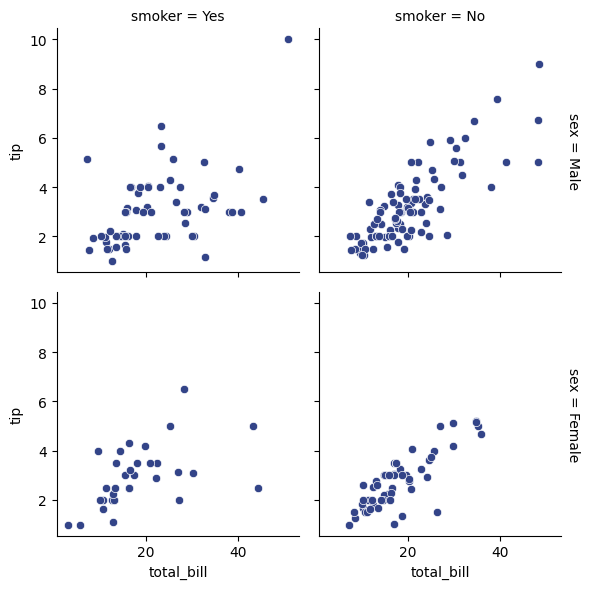

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tips = sns.load_dataset('tips')
print(tips.head())

# attend = sns.load_dataset("attention").query("subject <= 12")
# print(attend.head())    
grid = sns.FacetGrid(tips, col="smoker", row="sex",
                    #  col_wrap=4, 
                     height=3, # height of entire figure
                    #  ylim=(0, 10),
                     margin_titles=True)
grid.map(sns.scatterplot, "total_bill", "tip", color="#334488")
grid.figure.subplots_adjust(wspace=0.01, hspace=0.01)
grid.figure.tight_layout()

plt.show()

In [9]:
data_file = r"C:\Users\10552\OneDrive - Redlen Technologies\Code\spectrum-analyzer\sample_data\2024-07-11_masksweep_30min_Co57.csv"
# add parent directory to path
import sys
import os
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
sys.path.append(r"C:\Users\10552\OneDrive - Redlen Technologies\Code\spectrum-analyzer")

from data_handling_modules import TransformDf, ExtractModule, ExtractModuleStreamlit

bin_peak_input = 246
peak_halfwidth_input = 50

def parse_data(file_path_input):
    EM = ExtractModule(file_path_input)
    print(f"Number of lines in data file: {EM.count_lines()}")
    extracted_df_list = EM.extract_all_modules2df()

    TD = TransformDf()
    df_transformed_list = TD.transform_all_df(extracted_df_list)

    if bin_peak_input is not None and peak_halfwidth_input is not None:
        peak_halfwidth = peak_halfwidth_input
        df_transformed_list = TD.add_peak_counts_all(bin_peak_input, peak_halfwidth)
        # df_transformed_list = TD.add_bin_max_all(bin_peak_input, peak_halfwidth)
        
    x_positions = EM.extract_metadata_list(EM.csv_file, "stage_x_mm:")
    y_positions = EM.extract_metadata_list(EM.csv_file, "stage_y_mm:")
    heights = EM.extract_metadata_list(EM.csv_file, "height:")

    return (EM.number_of_modules, EM.n_pixels_x, EM.n_pixels_y, 
            x_positions, y_positions, heights, df_transformed_list)

N_MODULES, N_PIXELS_X, N_PIXELS_Y, x_positions, y_positions, heights, df_transformed_list = parse_data(data_file)

Number of lines in data file: 2862


In [10]:
df = df_transformed_list[0]

In [11]:
df.head()

,x_index,y_index,pixel_id,array_bins,total_count,total_counts_norm,is_edge,peak_count,non_peak_count
1,1,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",93117,0.912,True,55977,37140
2,1,2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",99774,0.977,True,59986,39788
3,1,3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",80721,0.790,True,52789,27932
4,1,4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",71010,0.695,True,45514,25496
5,1,5,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",70126,0.687,True,45433,24693


In [13]:
def calculate_bin_max(array, peak_bin, peak_halfwidth, threshold):
    """Finds the bin with the maximum counts"""
    # array = df["array_bins"]
    cropped_array = array[peak_bin - peak_halfwidth : peak_bin + peak_halfwidth]
    peak_height = np.max(cropped_array)
    if peak_height < threshold:
        return np.nan
    bin_max = np.argmax(cropped_array) + peak_bin - peak_halfwidth
    return bin_max

def calculate_peak_height(array, peak_bin, peak_halfwidth, threshold):
    """Find the max counts amongst all the bins"""
    cropped_array = array[peak_bin - peak_halfwidth : peak_bin + peak_halfwidth]
    peak_height = np.max(cropped_array)
    if peak_height < threshold:
        return np.nan
    return peak_height

# filter out rows with peak_counts < 200
df_above_thresh = df[df["peak_counts"] > 200]
df["bin_max"] = df.apply(
    lambda row: calculate_bin_max(row, 
                                bin_peak_input, 
                                peak_halfwidth_input))



KeyError: 'array_bins'

Text(0.5, 1.0, 'R^2 = -18.90, Pearson Correlation = 0.79')

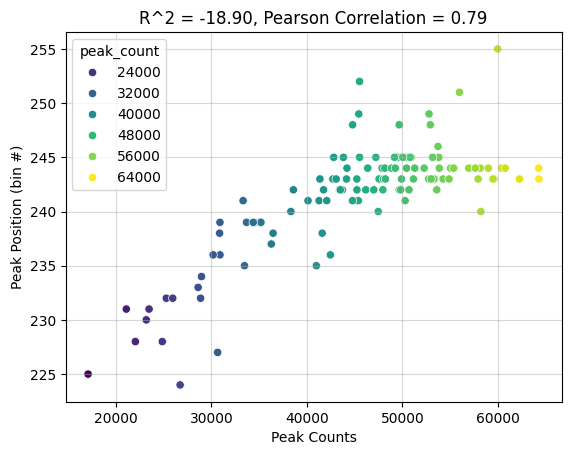

In [8]:
import seaborn as sns

# filter out data points with bin_max < 200
df = df[df['bin_max'] > 200]

x_value = 'peak_count'
y_value = 'bin_max'
sns.scatterplot(data=df, x=x_value, y=y_value, hue='peak_count', palette='viridis')
plt.xlabel("Peak Counts")
plt.ylabel("Peak Position (bin #)")
plt.grid(True, alpha=0.5)

# calculate R^2 value
from sklearn.metrics import r2_score
r2 = r2_score(df[x_value], df[y_value])

# calculate pearson correlation
from scipy.stats import pearsonr
corr, _ = pearsonr(df[x_value], df[y_value])

plt.title(f"R^2 = {r2:.2f}, Pearson Correlation = {corr:.2f}")

# plt.show()


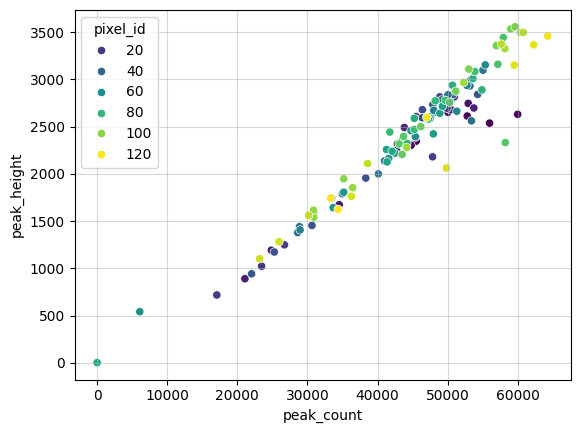

In [31]:
import seaborn as sns
x_value = 'peak_count'
y_value = 'peak_height'
sns.scatterplot(data=df, x=x_value, y=y_value, hue='pixel_id', palette='viridis')
plt.grid(True, alpha=0.5)

In [23]:
import plotly.express as px

y_value = 'peak_count'
x_value = 'bin_max'
fig = px.scatter(df, x='total_count', y='peak_count', title='Scatterplot: Peak Count vs Bin Max')
fig.update_layout(xaxis_title='Total Count', yaxis_title='Peak Count', showlegend=False)

# Add labels for x_index and y_index
# fig.update_traces(text=df['x_index'].astype(str) + ', ' + df['y_index'].astype(str), textposition='top center')

# fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'total_count=%{x}<br>peak_count=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([ 93117,  99774,  80721,  71010,  70126,  68434,  82414,  77591,  57062,
                           40426,  47240,  85356,  72832,  74571,  62524,  62917,  67771,  70501,
                           62719,  38253,  30439,  49837,  84147,  73923,  77599,  72000,  67553,
                           67683,  73071,  57704,  40476,  35539,  54046,  88354,  75934,  77752,
                           71523,  68096,  70980,  70348,  52100,  44634,  46102,  67269,  93572,
                           78014,  79320,  72491,  69833,  70800,  60620,  48481,  45856,  51849,
                           70347,  81878,  81115,  75653,  69665,  67605,  67164,      0,  51295,
                           54400,  62437,  77202,  78686,  71919,  72227,  61991,  64199,  65939,
                           39709,  62673,  66846,  75619,  83462,  86585,  69863,  70431,  65302,
                           63359,  68256,  76505,  79913,  85250,  83117,  79841,  98996,  65825,
                           63958,  64855,  69114,  76642,  83979,  86093,  86007,  78255,  61315,
                           53089,  47828,  56621,  66187,  78024,  84675,  88230,  88528,  86088,
                           57866,  53884,  43260,  47430,  64000,  80125,  91824,  97695, 102149,
                          101317,  74866,  53789,  61363]),
              'xaxis': 'x',
              'y': array([55977, 59986, 52789, 45514, 45433, 44785, 52926, 50034, 34528, 21082,
                          24852, 53732, 50439, 50934, 43823, 42810, 45514, 49670, 42720, 23466,
                          17078, 26719, 47845, 50475, 53806, 48875, 46395, 46371, 49913, 38320,
                          25272, 22029, 30647, 54266, 50809, 53169, 49520, 47881, 49174, 48158,
                          34976, 28605, 28865, 40990, 53388, 53295, 55034, 50042, 47558, 48014,
                          40116, 30891, 28957, 33463, 42459, 51298, 55366, 52751, 45386, 44775,
                           6090,     0, 33674, 35178, 41600, 47471, 47956, 48876, 49250, 41361,
                          41276, 43422,     9, 42079, 45239, 50691, 53603, 54887, 47222, 48226,
                          44195, 41748, 45230, 49666, 53865, 57935, 57159, 50288, 58220, 43713,
                          43065, 43500, 46163, 51158, 56942, 58998, 59624, 53011, 35180, 30896,
                          30856, 36456, 44149, 52280, 58160, 60393, 60775, 57641, 38585, 30178,
                          23176, 25946, 36270, 49820, 59494, 62261, 64308, 64276, 47008, 33316,
                          34376], dtype=int64),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'showlegend': False,
               'template': '...',
               'title': {'text': 'Scatterplot: Peak Count vs Bin Max'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Total Count'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Peak Count'}}}
})